Using device: cuda:0
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2):

mode: test.  Loss: 0.000 | F1: 1.000 | Recall: 1.000 | Accuracy: 1.000: 100%|█| 4343/4343 [02:37<0


[[599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.

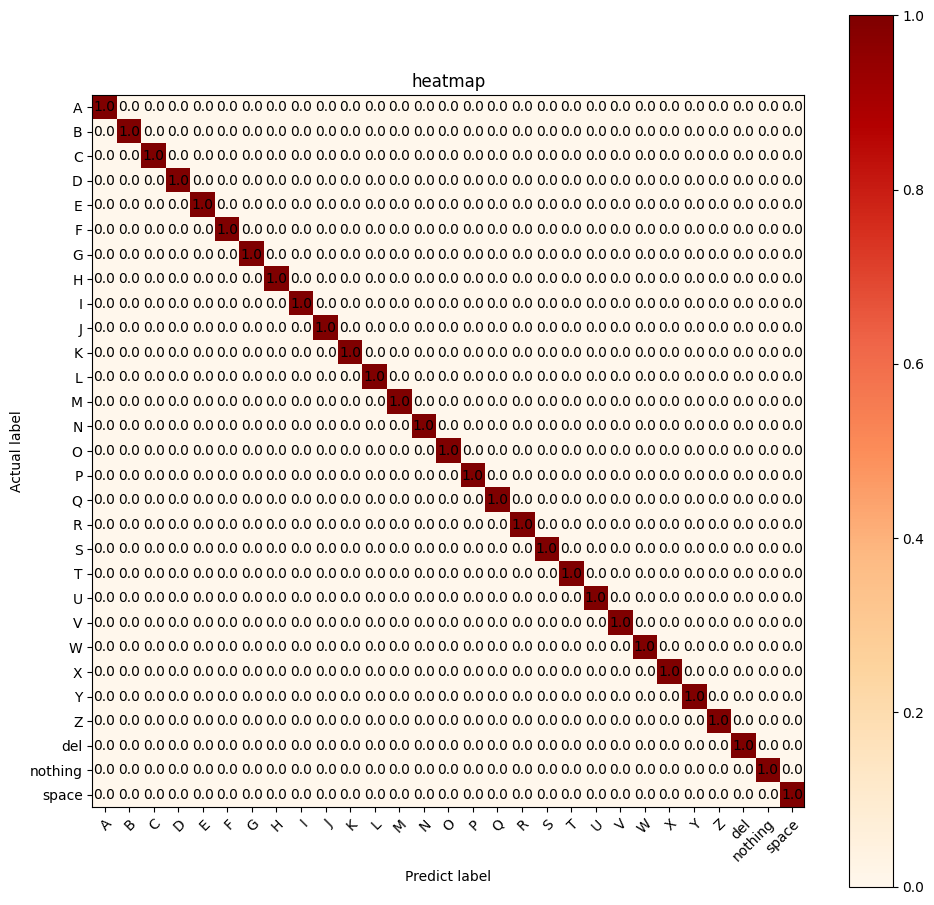

test result：
acc: 1.0, F1: 1.0, recall: 1.0
test has done，heatmap save atrecord


In [5]:
import os.path as osp
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, recall_score
import numpy as np
import torch.nn as nn
import timm

#set to gpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# fix the random seeds，make sure the result can be retaken, same as train
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# model set up

data_path = "./gestureDatabase_split"
model_path = "./savefile/efficientnet_b3a_pretrained_224_111/efficientnet_b3a_10epochs_accuracy1.00000_weights.pth"
model_name = 'efficientnet_b3a'
img_size = 224

params = {
    'model': 'efficientnet_b3a',
    "img_size": img_size,
    "test_dir": osp.join(data_path, "test"),
    'device': device,
    'batch_size': 4,
    'num_workers': 0,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),
    # "save_dir": "./savefile/"
}


# ----------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# define the model
class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)  # load pretrained model
        # self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path="pretrained/resnet50d_ra2-464e36ba.pth")
        # classifier
        if model_name[:3] == "res":
            n_features = self.model.fc.in_features  # fix the connect layer number
            self.model.fc = nn.Linear(n_features, out_features)  # change the class numebr
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features  # change full connect layer number
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)
        # resnet  change the all connect layer
        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

# ----------

def test(val_loader, model, params, class_names):
    #load and set model to validate
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    criterion = nn.CrossEntropyLoss()

    test_real_labels = []
    test_pre_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target.long())
            #process data to proper output
            target_numpy = target.cpu().numpy()
            y_pred = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            test_real_labels.extend(target_numpy)
            test_pre_labels.extend(y_pred)
            # calculate relavent data
            f1_macro = calculate_f1_macro(output, target)
            recall_macro = calculate_recall_macro(output, target)
            acc = accuracy(output, target)
            # update the relavent data
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            stream.set_description(
                "mode: {epoch}.  {metric_monitor}".format(epoch="test", metric_monitor=metric_monitor))
    class_names_length = len(class_names)
    #creat a zero matrix
    heat_maps = np.zeros((class_names_length, class_names_length))
    # fill in the test result
    for test_real_label, test_pre_label in zip(test_real_labels, test_pre_labels):
        heat_maps[test_real_label][test_pre_label] = heat_maps[test_real_label][test_pre_label] + 1
    #print the result
    print(heat_maps)
    heat_maps_sum = np.sum(heat_maps, axis=1).reshape(-1, 1)
    print(heat_maps_sum)
    print()
    heat_maps_float = heat_maps / heat_maps_sum
    print(heat_maps_float)
    show_heatmaps(title="heatmap", x_labels=class_names, y_labels=class_names, harvest=heat_maps_float,
                  save_name="./savefile/heat/heatmap_{}.png".format(model_name))
    
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['F1']["avg"], \
        metric_monitor.metrics['Recall']["avg"]


def show_heatmaps(title, x_labels, y_labels, harvest, save_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(harvest, cmap="OrRd")
    ax.set_xticks(np.arange(len(y_labels)))
    ax.set_yticks(np.arange(len(x_labels)))
    ax.set_xticklabels(y_labels)
    ax.set_yticklabels(x_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, round(harvest[i, j], 2), ha="center", va="center", color="black")
    ax.set_xlabel("Predict label")
    ax.set_ylabel("Actual label")
    ax.set_title(title)
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_name, dpi=100)
    plt.show()


if __name__ == '__main__':
    data_transforms = get_torch_transforms(img_size=params["img_size"])
    valid_transforms = data_transforms['val']
    test_dataset = datasets.ImageFolder(params["test_dir"], valid_transforms)
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True,
                             num_workers=params['num_workers'], pin_memory=True)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    acc, f1, recall = test(test_loader, model, params, class_names)
    print("test result：")
    print(f"acc: {acc}, F1: {f1}, recall: {recall}")
    print("test has done，heatmap save at{}".format("record"))

D:\pytorchMethod\pytorchClassification2\pytorchEnv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2):

mode: test.  Loss: 0.000 | F1: 1.000 | Recall: 1.000 | Accuracy: 1.000: 100%|██████| 1344/1344 [02:39<00:00,  8.41it/s]


[[199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 199.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 199.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0

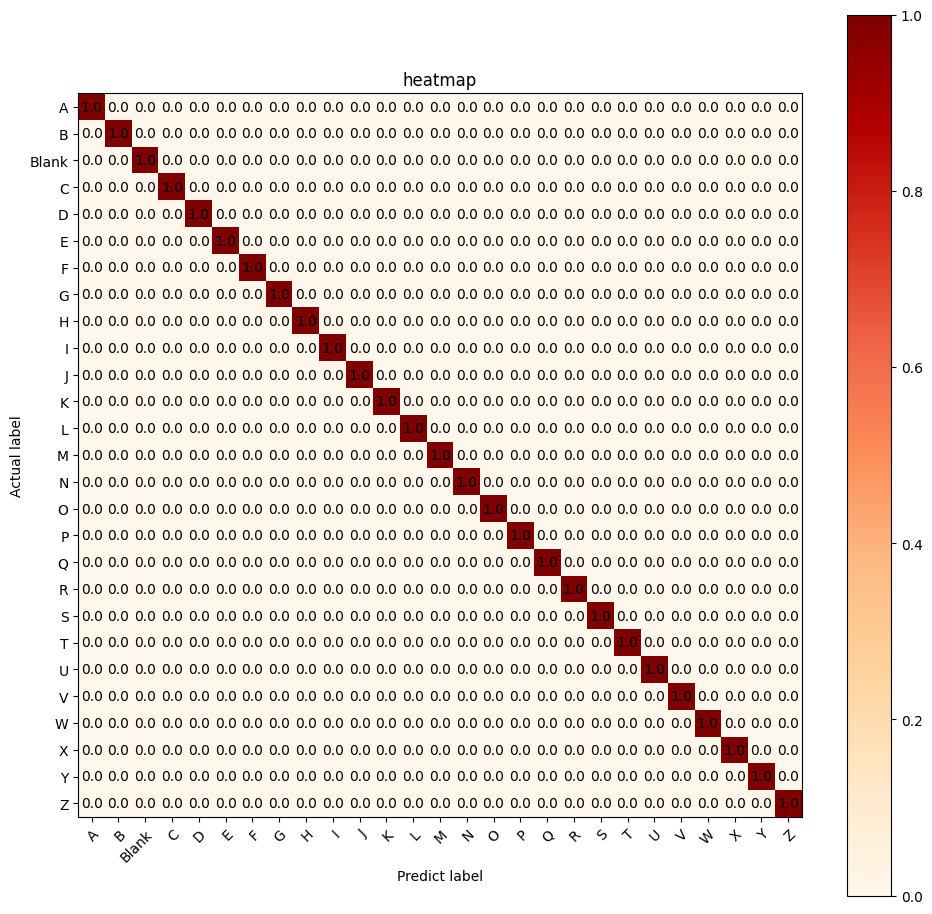

test result：
acc: 1.0, F1: 1.0, recall: 1.0
test has done，heatmap save atrecord


In [6]:
import os.path as osp
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, recall_score
import numpy as np
import torch.nn as nn
import timm

#set to gpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# fix the random seeds，make sure the result can be retaken, same as train
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# model set up

data_path = "./all2_split"
model_path = "./savefile/efficientnet_b3a_pretrained_224/efficientnet_b3a_10epochs_accuracy1.00000_weights.pth"
model_name = 'efficientnet_b3a'
img_size = 224

params = {
    'model': 'efficientnet_b3a',
    "img_size": img_size,
    "test_dir": osp.join(data_path, "test"),
    'device': device,
    'batch_size': 4,
    'num_workers': 0,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),
    # "save_dir": "./savefile/"
}


# ----------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# define the model
class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)  # load pretrained model
        # self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path="pretrained/resnet50d_ra2-464e36ba.pth")
        # classifier
        if model_name[:3] == "res":
            n_features = self.model.fc.in_features  # fix the connect layer number
            self.model.fc = nn.Linear(n_features, out_features)  # change the class numebr
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features  # change full connect layer number
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)
        # resnet  change the all connect layer
        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

# ----------

def test(val_loader, model, params, class_names):
    #load and set model to validate
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    criterion = nn.CrossEntropyLoss()

    test_real_labels = []
    test_pre_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target.long())
            #process data to proper output
            target_numpy = target.cpu().numpy()
            y_pred = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            test_real_labels.extend(target_numpy)
            test_pre_labels.extend(y_pred)
            # calculate relavent data
            f1_macro = calculate_f1_macro(output, target)
            recall_macro = calculate_recall_macro(output, target)
            acc = accuracy(output, target)
            # update the relavent data
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            stream.set_description(
                "mode: {epoch}.  {metric_monitor}".format(epoch="test", metric_monitor=metric_monitor))
    class_names_length = len(class_names)
    #creat a zero matrix
    heat_maps = np.zeros((class_names_length, class_names_length))
    # fill in the test result
    for test_real_label, test_pre_label in zip(test_real_labels, test_pre_labels):
        heat_maps[test_real_label][test_pre_label] = heat_maps[test_real_label][test_pre_label] + 1
    #print the result
    print(heat_maps)
    heat_maps_sum = np.sum(heat_maps, axis=1).reshape(-1, 1)
    print(heat_maps_sum)
    print()
    heat_maps_float = heat_maps / heat_maps_sum
    print(heat_maps_float)
    show_heatmaps(title="heatmap", x_labels=class_names, y_labels=class_names, harvest=heat_maps_float,
                  save_name="./savefile/heat/heatmap_{}.png".format(model_name))
    
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['F1']["avg"], \
        metric_monitor.metrics['Recall']["avg"]


def show_heatmaps(title, x_labels, y_labels, harvest, save_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(harvest, cmap="OrRd")
    ax.set_xticks(np.arange(len(y_labels)))
    ax.set_yticks(np.arange(len(x_labels)))
    ax.set_xticklabels(y_labels)
    ax.set_yticklabels(x_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, round(harvest[i, j], 2), ha="center", va="center", color="black")
    ax.set_xlabel("Predict label")
    ax.set_ylabel("Actual label")
    ax.set_title(title)
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_name, dpi=100)
    plt.show()


if __name__ == '__main__':
    data_transforms = get_torch_transforms(img_size=params["img_size"])
    valid_transforms = data_transforms['val']
    test_dataset = datasets.ImageFolder(params["test_dir"], valid_transforms)
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True,
                             num_workers=params['num_workers'], pin_memory=True)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    acc, f1, recall = test(test_loader, model, params, class_names)
    print("test result：")
    print(f"acc: {acc}, F1: {f1}, recall: {recall}")
    print("test has done，heatmap save at{}".format("record"))

Using device: cuda:0
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2):

mode: test.  Loss: 0.002 | F1: 1.000 | Recall: 1.000 | Accuracy: 1.000: 100%|██████| 4343/4343 [03:59<00:00, 18.16it/s]


[[600.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.

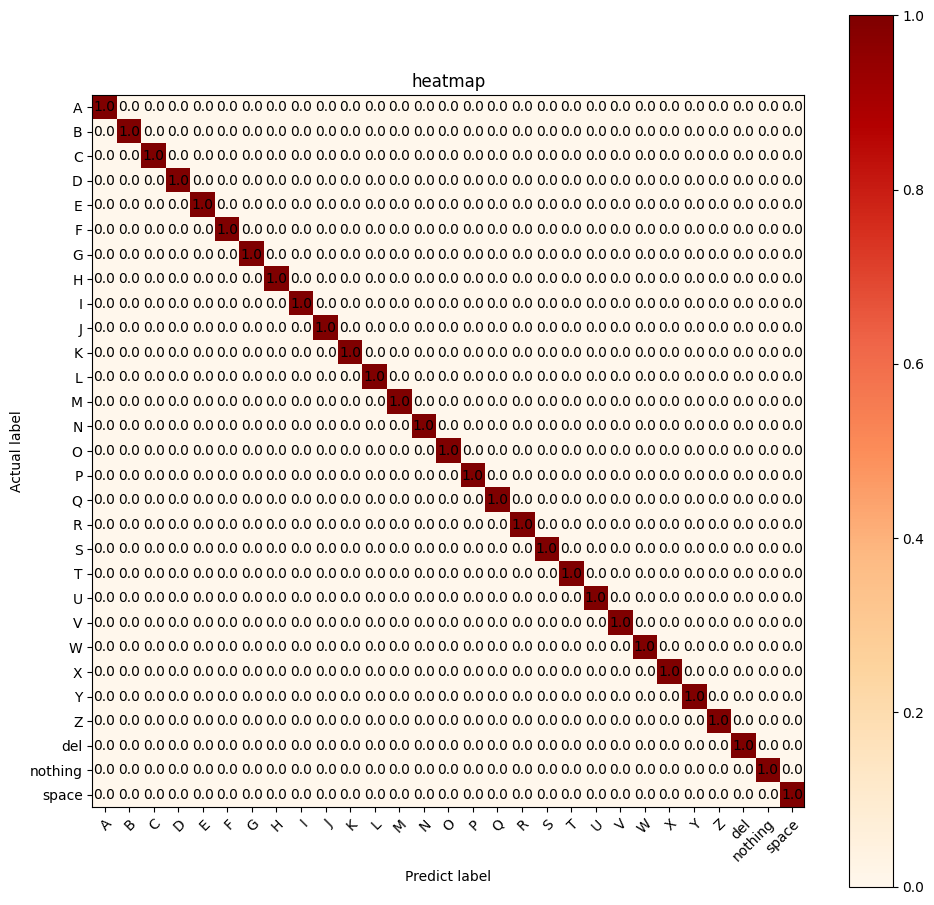

test result：
acc: 0.999884872208151, F1: 0.9998157955330417, recall: 0.9998157955330417
test has done，heatmap save atrecord


In [5]:
import os.path as osp
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, recall_score
import numpy as np
import torch.nn as nn
import timm

#set to gpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# fix the random seeds，make sure the result can be retaken, same as train
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# model set up

data_path = "./gestureDatabase_split20240122"
model_path = "./savefile/efficientnet_b3a_pretrained_224/efficientnet_b3a_e10bat42LR5.pth"
model_name = 'efficientnet_b3a'
img_size = 224

params = {
    'model': 'efficientnet_b3a',
    "img_size": img_size,
    "test_dir": osp.join(data_path, "test"),
    'device': device,
    'batch_size': 4,
    'num_workers': 0,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),
    # "save_dir": "./savefile/"
}


# ----------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# define the model
class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)  # load pretrained model
        # self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path="pretrained/resnet50d_ra2-464e36ba.pth")
        # classifier
        if model_name[:3] == "res":
            n_features = self.model.fc.in_features  # fix the connect layer number
            self.model.fc = nn.Linear(n_features, out_features)  # change the class numebr
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features  # change full connect layer number
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)
        # resnet  change the all connect layer
        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

# ----------

def test(val_loader, model, params, class_names):
    #load and set model to validate
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    criterion = nn.CrossEntropyLoss()

    test_real_labels = []
    test_pre_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target.long())
            #process data to proper output
            target_numpy = target.cpu().numpy()
            y_pred = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            test_real_labels.extend(target_numpy)
            test_pre_labels.extend(y_pred)
            # calculate relavent data
            f1_macro = calculate_f1_macro(output, target)
            recall_macro = calculate_recall_macro(output, target)
            acc = accuracy(output, target)
            # update the relavent data
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            stream.set_description(
                "mode: {epoch}.  {metric_monitor}".format(epoch="test", metric_monitor=metric_monitor))
    class_names_length = len(class_names)
    #creat a zero matrix
    heat_maps = np.zeros((class_names_length, class_names_length))
    # fill in the test result
    for test_real_label, test_pre_label in zip(test_real_labels, test_pre_labels):
        heat_maps[test_real_label][test_pre_label] = heat_maps[test_real_label][test_pre_label] + 1
    #print the result
    print(heat_maps)
    heat_maps_sum = np.sum(heat_maps, axis=1).reshape(-1, 1)
    print(heat_maps_sum)
    print()
    heat_maps_float = heat_maps / heat_maps_sum
    print(heat_maps_float)
    show_heatmaps(title="heatmap", x_labels=class_names, y_labels=class_names, harvest=heat_maps_float,
                  save_name="./savefile/heat/heatmap_{}.png".format(model_name))
    
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['F1']["avg"], \
        metric_monitor.metrics['Recall']["avg"]


def show_heatmaps(title, x_labels, y_labels, harvest, save_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(harvest, cmap="OrRd")
    ax.set_xticks(np.arange(len(y_labels)))
    ax.set_yticks(np.arange(len(x_labels)))
    ax.set_xticklabels(y_labels)
    ax.set_yticklabels(x_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, round(harvest[i, j], 2), ha="center", va="center", color="black")
    ax.set_xlabel("Predict label")
    ax.set_ylabel("Actual label")
    ax.set_title(title)
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_name, dpi=100)
    plt.show()


if __name__ == '__main__':
    data_transforms = get_torch_transforms(img_size=params["img_size"])
    valid_transforms = data_transforms['val']
    test_dataset = datasets.ImageFolder(params["test_dir"], valid_transforms)
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True,
                             num_workers=params['num_workers'], pin_memory=True)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    acc, f1, recall = test(test_loader, model, params, class_names)
    print("test result：")
    print(f"acc: {acc}, F1: {f1}, recall: {recall}")
    print("test has done，heatmap save at{}".format("record"))

Using device: cuda:0
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2):

mode: test.  Loss: 0.000 | F1: 1.000 | Recall: 1.000 | Accuracy: 1.000: 100%|██████| 4343/4343 [04:19<00:00, 16.74it/s]


[[600.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.

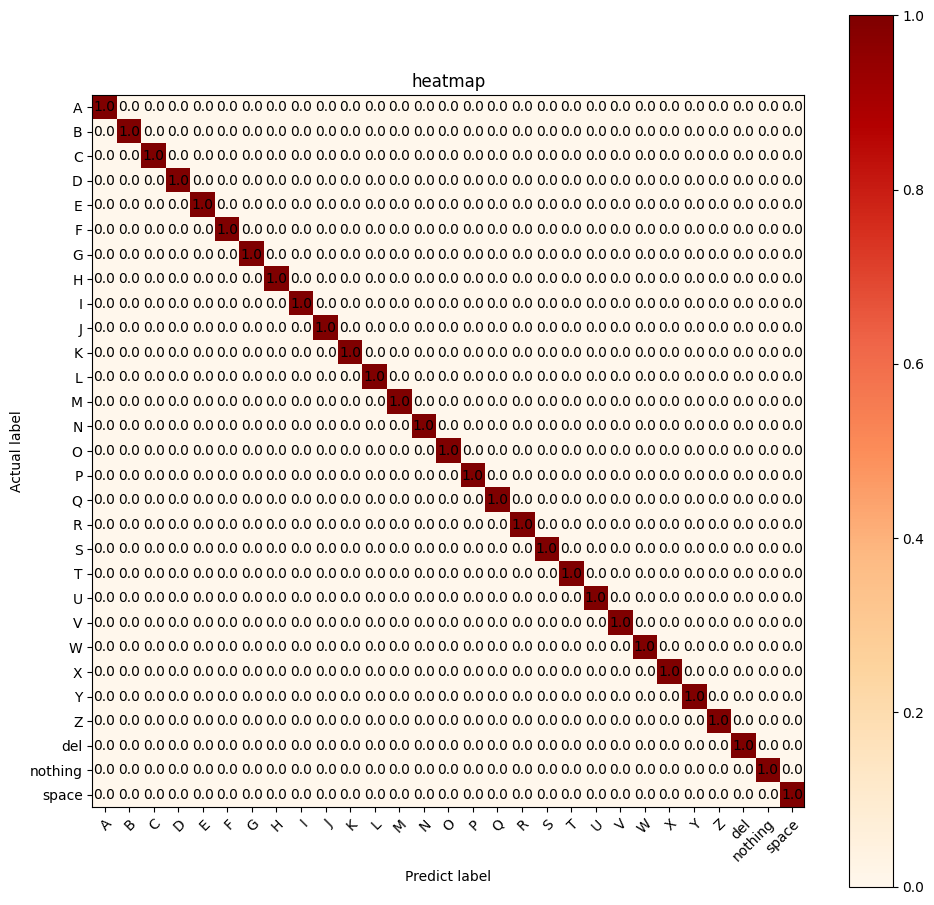

test result：
acc: 1.0, F1: 1.0, recall: 1.0
test has done，heatmap save atrecord


In [6]:
import os.path as osp
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, recall_score
import numpy as np
import torch.nn as nn
import timm

#set to gpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# fix the random seeds，make sure the result can be retaken, same as train
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# model set up

data_path = "./gestureDatabase_split20240122"
model_path = "./savefile/efficientnet_b3a_pretrained_224/efficientnet_b3a_20epochsLR5Batch36.pth"
model_name = 'efficientnet_b3a'
img_size = 224

params = {
    'model': 'efficientnet_b3a',
    "img_size": img_size,
    "test_dir": osp.join(data_path, "test"),
    'device': device,
    'batch_size': 4,
    'num_workers': 0,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),
    # "save_dir": "./savefile/"
}


# ----------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# define the model
class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)  # load pretrained model
        # self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path="pretrained/resnet50d_ra2-464e36ba.pth")
        # classifier
        if model_name[:3] == "res":
            n_features = self.model.fc.in_features  # fix the connect layer number
            self.model.fc = nn.Linear(n_features, out_features)  # change the class numebr
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features  # change full connect layer number
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)
        # resnet  change the all connect layer
        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

# ----------

def test(val_loader, model, params, class_names):
    #load and set model to validate
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    criterion = nn.CrossEntropyLoss()

    test_real_labels = []
    test_pre_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target.long())
            #process data to proper output
            target_numpy = target.cpu().numpy()
            y_pred = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            test_real_labels.extend(target_numpy)
            test_pre_labels.extend(y_pred)
            # calculate relavent data
            f1_macro = calculate_f1_macro(output, target)
            recall_macro = calculate_recall_macro(output, target)
            acc = accuracy(output, target)
            # update the relavent data
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            stream.set_description(
                "mode: {epoch}.  {metric_monitor}".format(epoch="test", metric_monitor=metric_monitor))
    class_names_length = len(class_names)
    #creat a zero matrix
    heat_maps = np.zeros((class_names_length, class_names_length))
    # fill in the test result
    for test_real_label, test_pre_label in zip(test_real_labels, test_pre_labels):
        heat_maps[test_real_label][test_pre_label] = heat_maps[test_real_label][test_pre_label] + 1
    #print the result
    print(heat_maps)
    heat_maps_sum = np.sum(heat_maps, axis=1).reshape(-1, 1)
    print(heat_maps_sum)
    print()
    heat_maps_float = heat_maps / heat_maps_sum
    print(heat_maps_float)
    show_heatmaps(title="heatmap", x_labels=class_names, y_labels=class_names, harvest=heat_maps_float,
                  save_name="./savefile/heat/heatmap_{}.png".format(model_name))
    
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['F1']["avg"], \
        metric_monitor.metrics['Recall']["avg"]


def show_heatmaps(title, x_labels, y_labels, harvest, save_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(harvest, cmap="OrRd")
    ax.set_xticks(np.arange(len(y_labels)))
    ax.set_yticks(np.arange(len(x_labels)))
    ax.set_xticklabels(y_labels)
    ax.set_yticklabels(x_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, round(harvest[i, j], 2), ha="center", va="center", color="black")
    ax.set_xlabel("Predict label")
    ax.set_ylabel("Actual label")
    ax.set_title(title)
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_name, dpi=100)
    plt.show()


if __name__ == '__main__':
    data_transforms = get_torch_transforms(img_size=params["img_size"])
    valid_transforms = data_transforms['val']
    test_dataset = datasets.ImageFolder(params["test_dir"], valid_transforms)
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True,
                             num_workers=params['num_workers'], pin_memory=True)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    acc, f1, recall = test(test_loader, model, params, class_names)
    print("test result：")
    print(f"acc: {acc}, F1: {f1}, recall: {recall}")
    print("test has done，heatmap save at{}".format("record"))

Using device: cuda:0
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2):

mode: test.  Loss: 0.000 | F1: 1.000 | Recall: 1.000 | Accuracy: 1.000: 100%|██████| 4343/4343 [03:09<00:00, 22.94it/s]


[[600.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0. 599.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.

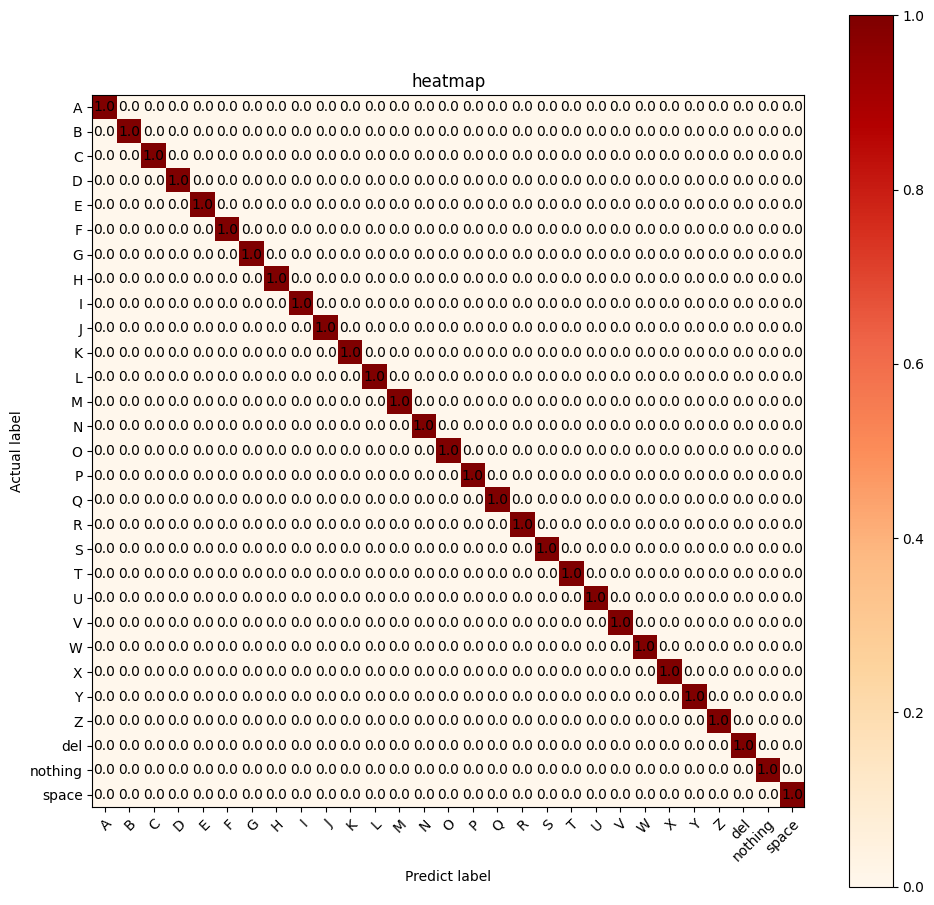

test result：
acc: 1.0, F1: 1.0, recall: 1.0
test has done，heatmap save atrecord


In [7]:
import os.path as osp
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, recall_score
import numpy as np
import torch.nn as nn
import timm

#set to gpu
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# fix the random seeds，make sure the result can be retaken, same as train
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# model set up

data_path = "./gestureDatabase_split20240122"
model_path = "./savefile/efficientnet_b3a_pretrained_224/efficientnet_b3a_20epochsbatch36LR4.pth"
model_name = 'efficientnet_b3a'
img_size = 224

params = {
    'model': 'efficientnet_b3a',
    "img_size": img_size,
    "test_dir": osp.join(data_path, "test"),
    'device': device,
    'batch_size': 4,
    'num_workers': 0,
    "num_classes": len(os.listdir(osp.join(data_path, "train"))),
    # "save_dir": "./savefile/"
}


# ----------

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)


def calculate_f1_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='macro')


def calculate_recall_macro(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average="macro", zero_division=0)


def get_torch_transforms(img_size=224):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation((-5, 5)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


# define the model
class SELFMODEL(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['num_classes'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)  # load pretrained model
        # self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path="pretrained/resnet50d_ra2-464e36ba.pth")
        # classifier
        if model_name[:3] == "res":
            n_features = self.model.fc.in_features  # fix the connect layer number
            self.model.fc = nn.Linear(n_features, out_features)  # change the class numebr
        elif model_name[:3] == "vit":
            n_features = self.model.head.in_features  # change full connect layer number
            self.model.head = nn.Linear(n_features, out_features)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features)
        # resnet  change the all connect layer
        print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

# ----------

def test(val_loader, model, params, class_names):
    #load and set model to validate
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    criterion = nn.CrossEntropyLoss()

    test_real_labels = []
    test_pre_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # load data
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target.long())
            #process data to proper output
            target_numpy = target.cpu().numpy()
            y_pred = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            test_real_labels.extend(target_numpy)
            test_pre_labels.extend(y_pred)
            # calculate relavent data
            f1_macro = calculate_f1_macro(output, target)
            recall_macro = calculate_recall_macro(output, target)
            acc = accuracy(output, target)
            # update the relavent data
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('F1', f1_macro)
            metric_monitor.update("Recall", recall_macro)
            metric_monitor.update('Accuracy', acc)
            stream.set_description(
                "mode: {epoch}.  {metric_monitor}".format(epoch="test", metric_monitor=metric_monitor))
    class_names_length = len(class_names)
    #creat a zero matrix
    heat_maps = np.zeros((class_names_length, class_names_length))
    # fill in the test result
    for test_real_label, test_pre_label in zip(test_real_labels, test_pre_labels):
        heat_maps[test_real_label][test_pre_label] = heat_maps[test_real_label][test_pre_label] + 1
    #print the result
    print(heat_maps)
    heat_maps_sum = np.sum(heat_maps, axis=1).reshape(-1, 1)
    print(heat_maps_sum)
    print()
    heat_maps_float = heat_maps / heat_maps_sum
    print(heat_maps_float)
    show_heatmaps(title="heatmap", x_labels=class_names, y_labels=class_names, harvest=heat_maps_float,
                  save_name="./savefile/heat/heatmap_{}.png".format(model_name))
    
    return metric_monitor.metrics['Accuracy']["avg"], metric_monitor.metrics['F1']["avg"], \
        metric_monitor.metrics['Recall']["avg"]


def show_heatmaps(title, x_labels, y_labels, harvest, save_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(harvest, cmap="OrRd")
    ax.set_xticks(np.arange(len(y_labels)))
    ax.set_yticks(np.arange(len(x_labels)))
    ax.set_xticklabels(y_labels)
    ax.set_yticklabels(x_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, round(harvest[i, j], 2), ha="center", va="center", color="black")
    ax.set_xlabel("Predict label")
    ax.set_ylabel("Actual label")
    ax.set_title(title)
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_name, dpi=100)
    plt.show()


if __name__ == '__main__':
    data_transforms = get_torch_transforms(img_size=params["img_size"])
    valid_transforms = data_transforms['val']
    test_dataset = datasets.ImageFolder(params["test_dir"], valid_transforms)
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True,
                             num_workers=params['num_workers'], pin_memory=True)
    model = SELFMODEL(model_name=params['model'], out_features=params['num_classes'], pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    acc, f1, recall = test(test_loader, model, params, class_names)
    print("test result：")
    print(f"acc: {acc}, F1: {f1}, recall: {recall}")
    print("test has done，heatmap save at{}".format("record"))